In [1]:
!git clone https://github.com/korfoo12/OptMLProject OptMLProject

Cloning into 'OptMLProject'...
remote: Enumerating objects: 142, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 142 (delta 76), reused 96 (delta 36), pack-reused 0
Receiving objects: 100% (142/142), 8.42 MiB | 22.45 MiB/s, done.
Resolving deltas: 100% (76/76), done.


In [2]:
import sys
sys.path.insert(0, '/kaggle/working/OptMLProject/code/')

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torchvision.models import vgg11

from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt

from OptMLProject.code.lib.models import model
from OptMLProject.code.lib.server import Server
from OptMLProject.code.lib.client import Client
from OptMLProject.code.lib.data_helper import *
from OptMLProject.code.lib.train_helper import *
from OptMLProject.code.lib.plots import plot_loss_epoch

In [4]:
if torch.backends.mps.is_available():
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
device

'cuda'

In [5]:
seed_generators()

In [6]:
train_dataset = CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
train_dataset

100%|██████████| 170498071/170498071 [00:01<00:00, 96869757.80it/s] 


Extracting data/cifar-10-python.tar.gz to data


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_dataset = CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
test_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
num_clients = 8
num_classes = 10

In [9]:
def run_FedAvg(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []

    server.reset_weights()
    for i in range(rounds):
        print(f'>>> Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        valid_loss, valid_acc = evaluate(server.net,valid_loader)
        
        print(f'''
Server :
    - training loss = {train_loss:.4f}
    - training accuracy = {train_acc:.4f}
    - validation loss = {valid_loss:.4f}
    - validation accuracy = {valid_acc:.4f}
        ''')
        
        history.append([train_loss, valid_loss, train_acc, valid_acc])
    return history

In [10]:
def run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,**kwargs):
    folds = KFold(n_splits=n_splits,shuffle=True,random_state=42).split(np.arange(len(train_dataset)))

    results = []
    for fold, (train_idx,valid_idx) in enumerate(folds):
        print("="*25)
        print(f"Fold #{fold}")
        print("="*25)

        # create train and validation subsets
        train_subset = Subset(train_dataset, train_idx)
        valid_subset = Subset(train_dataset, valid_idx)

        # split data between users
        partition = partition_by_class(train_subset)
        clients = [Client(i,d,model().to(device)) for i,d in enumerate(split(partition,proportions),start=1)]
        server = Server(model().to(device))
        
        for c in clients:
            print(f"client {c.client_id} : {len(c.dataset)} samples")
        print()
        
        history = run_FedAvg(server,clients,device,train_subset,valid_subset,rounds,epochs,batch_size,optimizer,lr,**kwargs)
        
        plot_loss_epoch(history)
        
        results.append(history[-1][-1])
                
    return torch.tensor(results).mean()

# IID Dataset

In [11]:
proportions = generate_proportions(num_clients, num_classes,alpha=10e8)

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.4708, Accuracy = 0.5046
client 2 : Loss = 1.3151, Accuracy = 0.5515
client 3 : Loss = 1.5134, Accuracy = 0.4684
client 4 : Loss = 1.3592, Accuracy = 0.5334
client 5 : Loss = 1.4720, Accuracy = 0.5031
client 6 : Loss = 1.2544, Accuracy = 0.5549
client 7 : Loss = 1.3804, Accuracy = 0.5257
client 8 : Loss = 1.5846, Accuracy = 0.4734

Server :
    - training loss = 1.5034
    - training accuracy = 0.4617
    - validation loss = 1.5302
    - validation accuracy = 0.4498
        
>>> Round 2 ...
client 1 : Loss = 1.0512, Accuracy = 0.6362
client 2 : Loss = 0.9812, Accuracy = 0.6495
client 3 : Loss = 1.0229, Accuracy = 0.6440
client 4 : Loss = 0.9580, Accuracy = 0.6615
client 5 : Loss = 1.0097, Accuracy = 0.6497
client 6 : Loss = 1.1216, Accuracy = 0.6023
clie

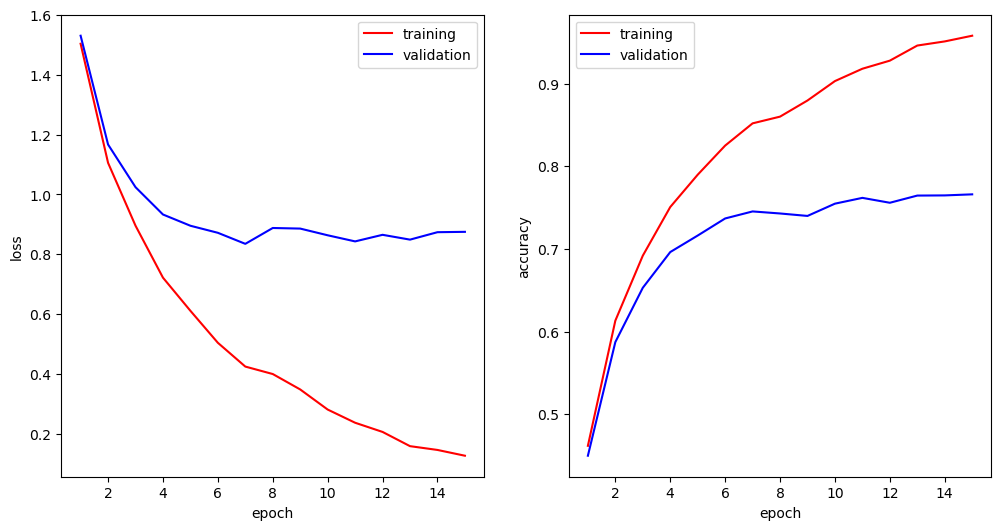

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.1977, Accuracy = 0.5884
client 2 : Loss = 1.4351, Accuracy = 0.5217
client 3 : Loss = 1.2110, Accuracy = 0.5736
client 4 : Loss = 1.3723, Accuracy = 0.5336
client 5 : Loss = 1.3151, Accuracy = 0.5479
client 6 : Loss = 1.2398, Accuracy = 0.5723
client 7 : Loss = 1.6627, Accuracy = 0.4637
client 8 : Loss = 1.3171, Accuracy = 0.5436

Server :
    - training loss = 1.5038
    - training accuracy = 0.4548
    - validation loss = 1.5193
    - validation accuracy = 0.4465
        
>>> Round 2 ...
client 1 : Loss = 0.8907, Accuracy = 0.6839
client 2 : Loss = 1.2614, Accuracy = 0.5750
client 3 : Loss = 0.9183, Accuracy = 0.6782
client 4 : Loss = 0.8954, Accuracy = 0.6811
client 5 : Loss = 1.0405, Accuracy = 0.6397
client 6 : Loss = 0.9152, Accuracy = 0.6795
clie

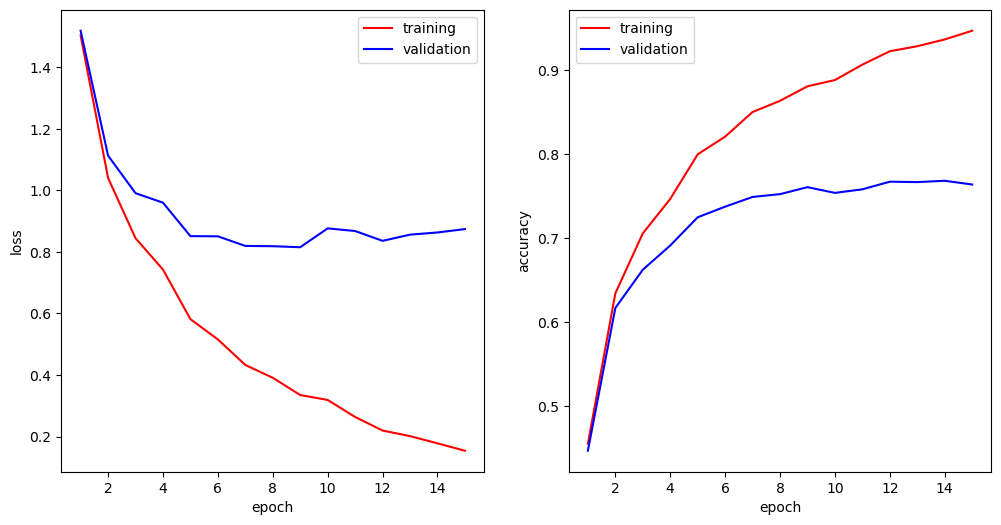

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.3187, Accuracy = 0.5588
client 2 : Loss = 1.2918, Accuracy = 0.5597
client 3 : Loss = 1.2884, Accuracy = 0.5533
client 4 : Loss = 1.3340, Accuracy = 0.5416
client 5 : Loss = 1.2902, Accuracy = 0.5410
client 6 : Loss = 1.3028, Accuracy = 0.5473
client 7 : Loss = 1.2227, Accuracy = 0.5790
client 8 : Loss = 1.3791, Accuracy = 0.5328

Server :
    - training loss = 1.4516
    - training accuracy = 0.4741
    - validation loss = 1.4728
    - validation accuracy = 0.4651
        
>>> Round 2 ...
client 1 : Loss = 0.9822, Accuracy = 0.6566
client 2 : Loss = 0.9719, Accuracy = 0.6498
client 3 : Loss = 0.9732, Accuracy = 0.6631
client 4 : Loss = 0.8007, Accuracy = 0.7234
client 5 : Loss = 0.9829, Accuracy = 0.6505
client 6 : Loss = 0.9185, Accuracy = 0.6695
clie

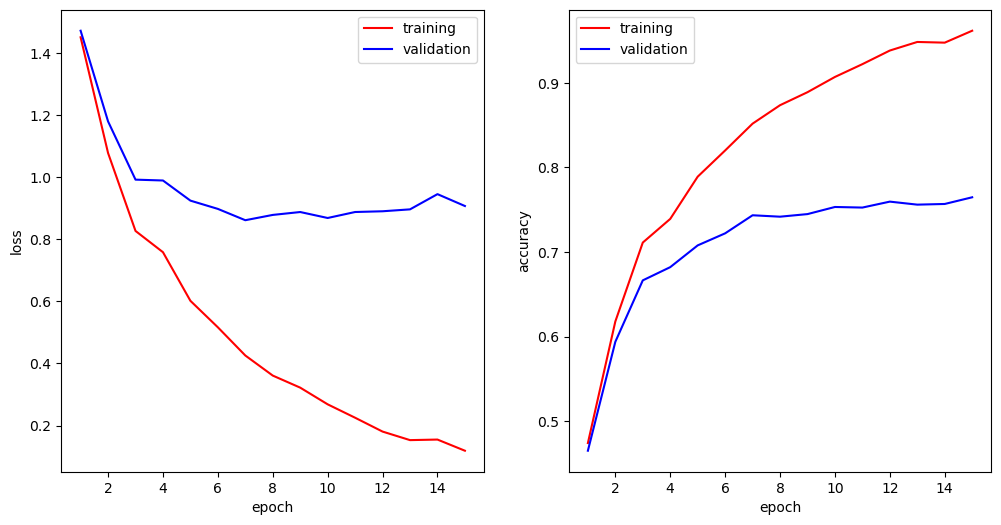

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.4249, Accuracy = 0.5168
client 2 : Loss = 1.2850, Accuracy = 0.5640
client 3 : Loss = 1.3436, Accuracy = 0.5503
client 4 : Loss = 1.3901, Accuracy = 0.5295
client 5 : Loss = 1.2688, Accuracy = 0.5602
client 6 : Loss = 1.2488, Accuracy = 0.5695
client 7 : Loss = 1.3565, Accuracy = 0.5360
client 8 : Loss = 1.3485, Accuracy = 0.5456

Server :
    - training loss = 1.4346
    - training accuracy = 0.4846
    - validation loss = 1.4578
    - validation accuracy = 0.4787
        
>>> Round 2 ...
client 1 : Loss = 0.9299, Accuracy = 0.6739
client 2 : Loss = 0.9158, Accuracy = 0.6822
client 3 : Loss = 1.0592, Accuracy = 0.6234
client 4 : Loss = 1.0196, Accuracy = 0.6383
client 5 : Loss = 0.9187, Accuracy = 0.6749
client 6 : Loss = 0.8636, Accuracy = 0.6990
clie

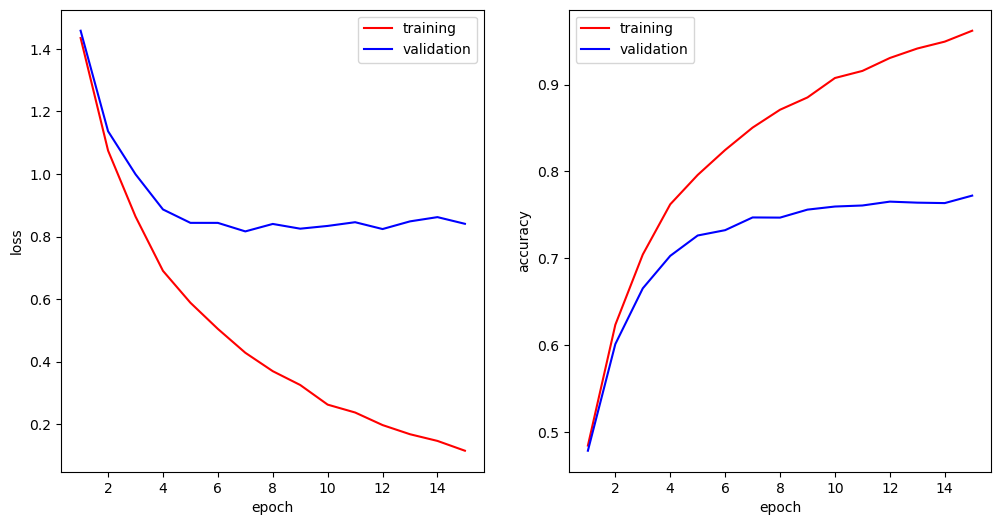

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.3049, Accuracy = 0.5586
client 2 : Loss = 1.1982, Accuracy = 0.5684
client 3 : Loss = 1.3475, Accuracy = 0.5379
client 4 : Loss = 1.4905, Accuracy = 0.4988
client 5 : Loss = 1.2958, Accuracy = 0.5445
client 6 : Loss = 1.3937, Accuracy = 0.5117
client 7 : Loss = 1.2881, Accuracy = 0.5514
client 8 : Loss = 1.3500, Accuracy = 0.5262

Server :
    - training loss = 1.4680
    - training accuracy = 0.4671
    - validation loss = 1.5014
    - validation accuracy = 0.4558
        
>>> Round 2 ...
client 1 : Loss = 1.0310, Accuracy = 0.6344
client 2 : Loss = 0.9844, Accuracy = 0.6502
client 3 : Loss = 1.0172, Accuracy = 0.6469
client 4 : Loss = 1.0049, Accuracy = 0.6576
client 5 : Loss = 0.8958, Accuracy = 0.6886
client 6 : Loss = 1.1000, Accuracy = 0.6202
clie

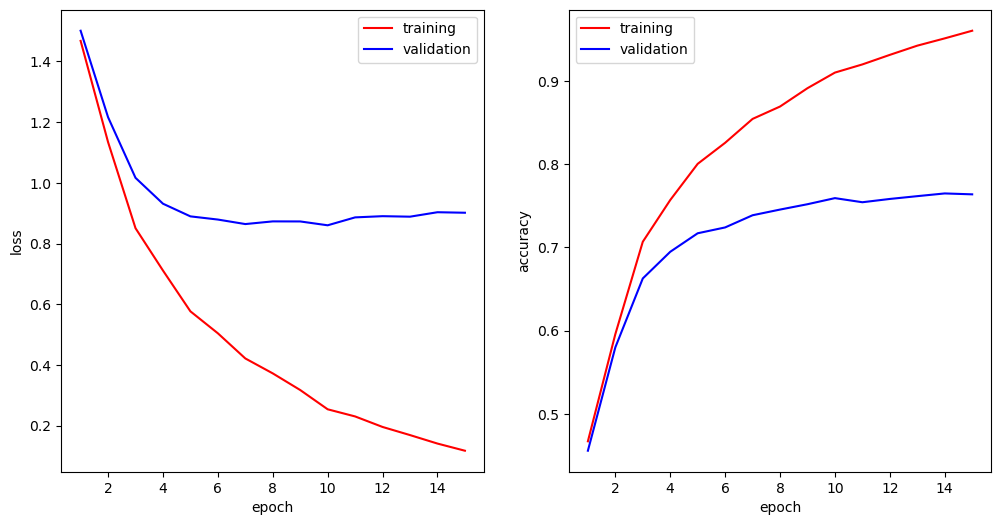

Fold #0
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 4999 samples
client 7 : 5001 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.8144, Accuracy = 0.3154
client 2 : Loss = 1.7074, Accuracy = 0.3734
client 3 : Loss = 1.7242, Accuracy = 0.3582
client 4 : Loss = 1.6633, Accuracy = 0.3848
client 5 : Loss = 1.7011, Accuracy = 0.3695
client 6 : Loss = 1.8788, Accuracy = 0.3108
client 7 : Loss = 1.6261, Accuracy = 0.4047
client 8 : Loss = 1.7908, Accuracy = 0.3187

Server :
    - training loss = 2.3191
    - training accuracy = 0.0990
    - validation loss = 2.3161
    - validation accuracy = 0.1035
        
>>> Round 2 ...
client 1 : Loss = 1.8084, Accuracy = 0.2998
client 2 : Loss = 1.6655, Accuracy = 0.3757
client 3 : Loss = 1.6820, Accuracy = 0.3747
client 4 : Loss = 1.6241, Accuracy = 0.3934
client 5 : Loss = 1.7412, Accuracy = 0.3378
client 6 : Loss = 1.7797, Accuracy = 0.3169
clie

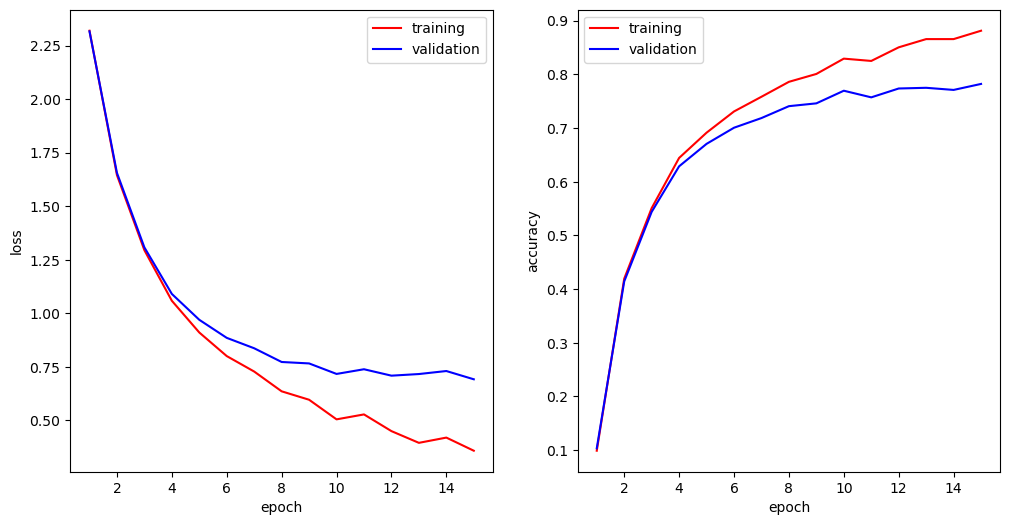

Fold #1
client 1 : 5002 samples
client 2 : 4996 samples
client 3 : 5002 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5001 samples
client 7 : 4996 samples
client 8 : 5002 samples

>>> Round 1 ...
client 1 : Loss = 1.6280, Accuracy = 0.4002
client 2 : Loss = 1.9540, Accuracy = 0.2551
client 3 : Loss = 1.7494, Accuracy = 0.3604
client 4 : Loss = 2.0883, Accuracy = 0.1936
client 5 : Loss = 1.9070, Accuracy = 0.2797
client 6 : Loss = 1.8626, Accuracy = 0.3108
client 7 : Loss = 1.8983, Accuracy = 0.2922
client 8 : Loss = 1.8682, Accuracy = 0.3170

Server :
    - training loss = 2.3024
    - training accuracy = 0.1032
    - validation loss = 2.3044
    - validation accuracy = 0.1030
        
>>> Round 2 ...
client 1 : Loss = 1.9290, Accuracy = 0.2640
client 2 : Loss = 2.0204, Accuracy = 0.2406
client 3 : Loss = 1.9632, Accuracy = 0.2120
client 4 : Loss = 1.9471, Accuracy = 0.2357
client 5 : Loss = 1.9768, Accuracy = 0.2275
client 6 : Loss = 1.9227, Accuracy = 0.2595
clie

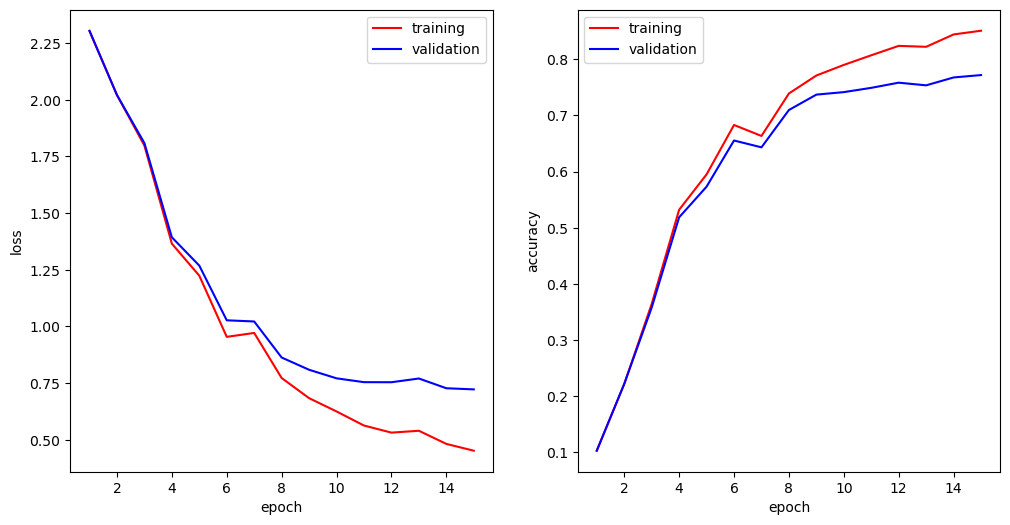

Fold #2
client 1 : 5000 samples
client 2 : 4999 samples
client 3 : 5000 samples
client 4 : 5001 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 4999 samples
client 8 : 5000 samples

>>> Round 1 ...
client 1 : Loss = 1.6817, Accuracy = 0.3820
client 2 : Loss = 1.8852, Accuracy = 0.2857
client 3 : Loss = 1.9019, Accuracy = 0.2850
client 4 : Loss = 1.7287, Accuracy = 0.3528
client 5 : Loss = 1.7339, Accuracy = 0.3483
client 6 : Loss = 1.7060, Accuracy = 0.3738
client 7 : Loss = 1.7348, Accuracy = 0.3624
client 8 : Loss = 1.7843, Accuracy = 0.3389

Server :
    - training loss = 2.3233
    - training accuracy = 0.1017
    - validation loss = 2.3233
    - validation accuracy = 0.1022
        
>>> Round 2 ...
client 1 : Loss = 1.7046, Accuracy = 0.3592
client 2 : Loss = 1.7751, Accuracy = 0.3239
client 3 : Loss = 1.7492, Accuracy = 0.3504
client 4 : Loss = 1.7293, Accuracy = 0.3480
client 5 : Loss = 1.6867, Accuracy = 0.3705
client 6 : Loss = 1.7240, Accuracy = 0.3457
clie

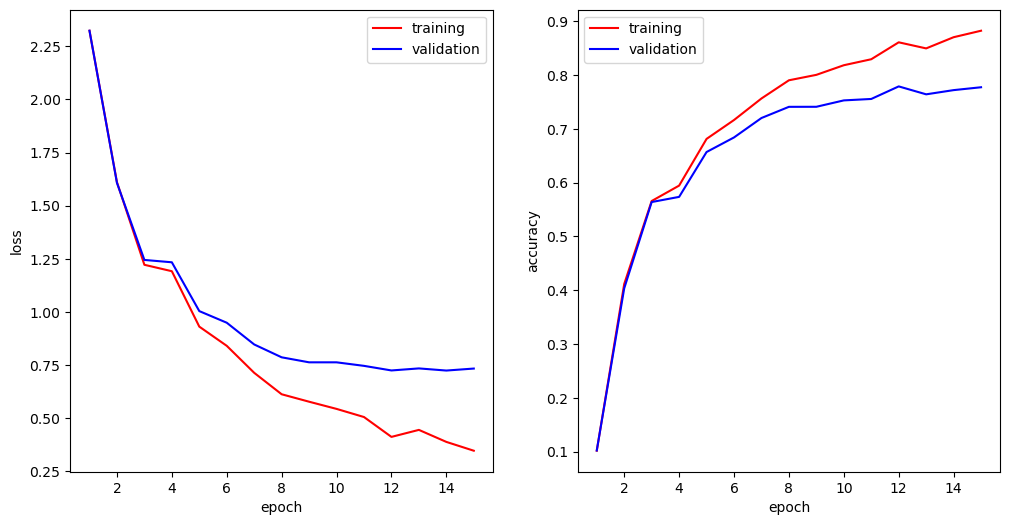

Fold #3
client 1 : 4999 samples
client 2 : 5002 samples
client 3 : 4998 samples
client 4 : 5000 samples
client 5 : 5001 samples
client 6 : 5000 samples
client 7 : 5001 samples
client 8 : 4999 samples

>>> Round 1 ...
client 1 : Loss = 1.7497, Accuracy = 0.3588
client 2 : Loss = 1.6651, Accuracy = 0.3819
client 3 : Loss = 1.9060, Accuracy = 0.3090
client 4 : Loss = 1.7789, Accuracy = 0.3332
client 5 : Loss = 1.7146, Accuracy = 0.3729
client 6 : Loss = 1.8305, Accuracy = 0.3129
client 7 : Loss = 1.6950, Accuracy = 0.3561
client 8 : Loss = 1.7992, Accuracy = 0.3232

Server :
    - training loss = 2.3115
    - training accuracy = 0.0997
    - validation loss = 2.3117
    - validation accuracy = 0.1008
        
>>> Round 2 ...
client 1 : Loss = 1.7887, Accuracy = 0.3261
client 2 : Loss = 1.6992, Accuracy = 0.3690
client 3 : Loss = 1.7725, Accuracy = 0.3249
client 4 : Loss = 1.8086, Accuracy = 0.3320
client 5 : Loss = 1.6891, Accuracy = 0.3726
client 6 : Loss = 1.6978, Accuracy = 0.3586
clie

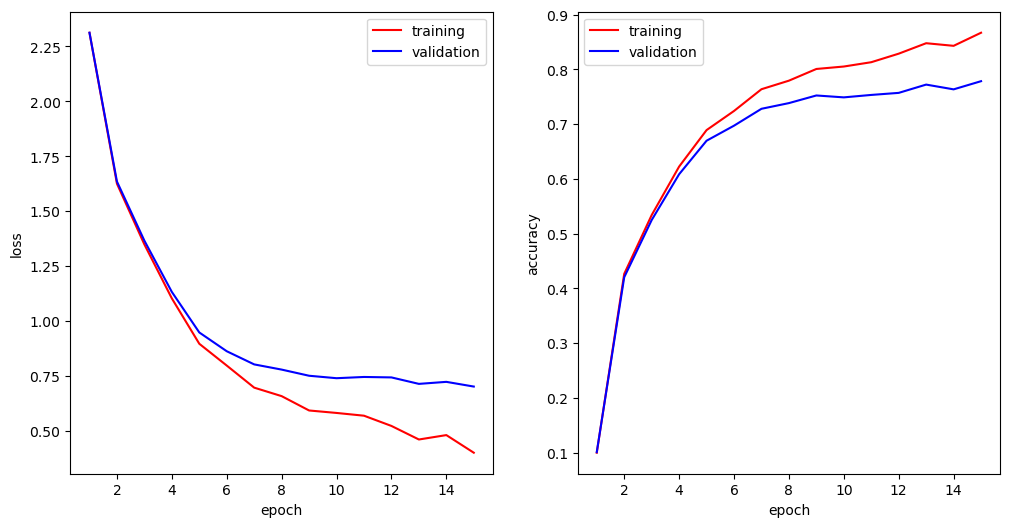

Fold #4
client 1 : 5000 samples
client 2 : 5000 samples
client 3 : 5000 samples
client 4 : 4999 samples
client 5 : 5002 samples
client 6 : 4998 samples
client 7 : 5000 samples
client 8 : 5001 samples

>>> Round 1 ...
client 1 : Loss = 1.6783, Accuracy = 0.3963
client 2 : Loss = 1.7395, Accuracy = 0.3490
client 3 : Loss = 1.7493, Accuracy = 0.3643
client 4 : Loss = 1.7250, Accuracy = 0.3590
client 5 : Loss = 1.6352, Accuracy = 0.3874
client 6 : Loss = 1.8578, Accuracy = 0.3076
client 7 : Loss = 1.7376, Accuracy = 0.3465
client 8 : Loss = 1.7555, Accuracy = 0.3448

Server :
    - training loss = 2.3125
    - training accuracy = 0.1026
    - validation loss = 2.3167
    - validation accuracy = 0.0949
        
>>> Round 2 ...
client 1 : Loss = 1.7570, Accuracy = 0.3557
client 2 : Loss = 1.6575, Accuracy = 0.3979
client 3 : Loss = 1.6596, Accuracy = 0.3689
client 4 : Loss = 1.7215, Accuracy = 0.3624
client 5 : Loss = 1.5980, Accuracy = 0.4082
client 6 : Loss = 1.6694, Accuracy = 0.3736
clie

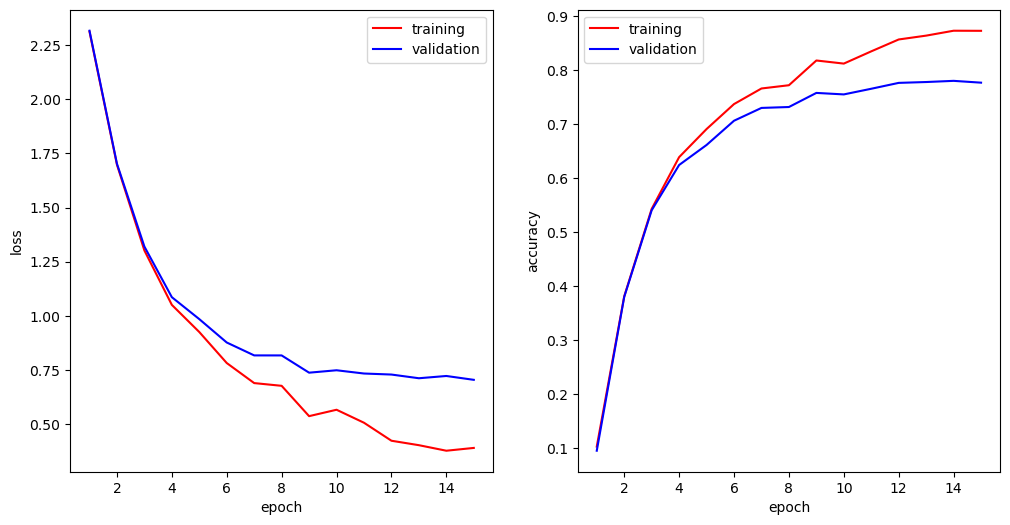

CPU times: user 2h 30min 19s, sys: 21.2 s, total: 2h 30min 40s
Wall time: 2h 31min 26s


In [12]:
%%time
n_splits = 5
rounds = 15
batch_size = 128
epochs = 5
momentums = [0.5, 0.95]
optimizer = optim.SGD
lr = 0.1
results = []
for momentum in momentums:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,momentum=momentum)
    results.append((lr,res))
    

In [13]:
print("="*25)
print(f"RESULTS")
print("="*25)
for momentum,res in results:
    print(f"Momentum = {momentum:.4f} : Accuracy = {res}")
print()

RESULTS
Momentum = 0.1000 : Accuracy = 0.7660799026489258
Momentum = 0.1000 : Accuracy = 0.7772349715232849



# Non-IID Dataset

In [14]:
# split data with alpha=10e8 for iid
proportions = generate_proportions(num_clients,num_classes, alpha=0.1)
proportions

[tensor([3.1529e-03, 1.0814e-01, 9.0058e-04, 1.5195e-01, 5.0014e-06, 2.0548e-05,
         6.6584e-01, 6.9988e-02]),
 tensor([5.8696e-09, 7.0319e-02, 2.2847e-12, 6.4945e-06, 3.5098e-05, 9.2963e-01,
         5.3018e-18, 1.1051e-05]),
 tensor([5.6523e-02, 6.2947e-17, 6.3877e-06, 1.7623e-01, 1.6170e-05, 8.5054e-05,
         2.2585e-02, 7.4456e-01]),
 tensor([2.6082e-06, 6.0159e-02, 2.0989e-05, 9.3652e-01, 2.9445e-08, 7.1491e-08,
         2.9122e-03, 3.8162e-04]),
 tensor([4.3850e-08, 1.6961e-05, 4.3917e-05, 6.4730e-01, 2.5442e-05, 6.3866e-06,
         7.8649e-02, 2.7396e-01]),
 tensor([2.1650e-01, 2.8710e-05, 9.7273e-02, 7.1397e-09, 4.3935e-04, 6.8500e-01,
         6.6463e-04, 9.1747e-05]),
 tensor([6.6785e-01, 5.1495e-06, 5.9210e-06, 2.9241e-01, 4.4098e-03, 2.2597e-02,
         4.6136e-06, 1.2717e-02]),
 tensor([2.6260e-10, 2.8049e-21, 1.9909e-01, 1.0156e-01, 6.9616e-01, 3.1795e-03,
         1.4252e-05, 1.4050e-08]),
 tensor([1.0884e-09, 6.8355e-02, 6.6203e-05, 5.3408e-02, 8.0211e-01, 3.9

Fold #0
client 1 : 3774 samples
client 2 : 3798 samples
client 3 : 1747 samples
client 4 : 10128 samples
client 5 : 6045 samples
client 6 : 6572 samples
client 7 : 3442 samples
client 8 : 4494 samples

>>> Round 1 ...
client 1 : Loss = 0.2395, Accuracy = 0.9121
client 2 : Loss = 0.2650, Accuracy = 0.9011
client 3 : Loss = 0.2349, Accuracy = 0.9116
client 4 : Loss = 0.8081, Accuracy = 0.7146
client 5 : Loss = 0.0657, Accuracy = 0.9780
client 6 : Loss = 0.0833, Accuracy = 0.9733
client 7 : Loss = 0.3073, Accuracy = 0.8906
client 8 : Loss = 0.7133, Accuracy = 0.7336

Server :
    - training loss = 2.1185
    - training accuracy = 0.3263
    - validation loss = 2.1434
    - validation accuracy = 0.3163
        
>>> Round 2 ...
client 1 : Loss = 0.1338, Accuracy = 0.9523
client 2 : Loss = 0.1901, Accuracy = 0.9313
client 3 : Loss = 0.1128, Accuracy = 0.9637
client 4 : Loss = 0.6460, Accuracy = 0.7699
client 5 : Loss = 0.0545, Accuracy = 0.9805
client 6 : Loss = 0.0464, Accuracy = 0.9845
cli

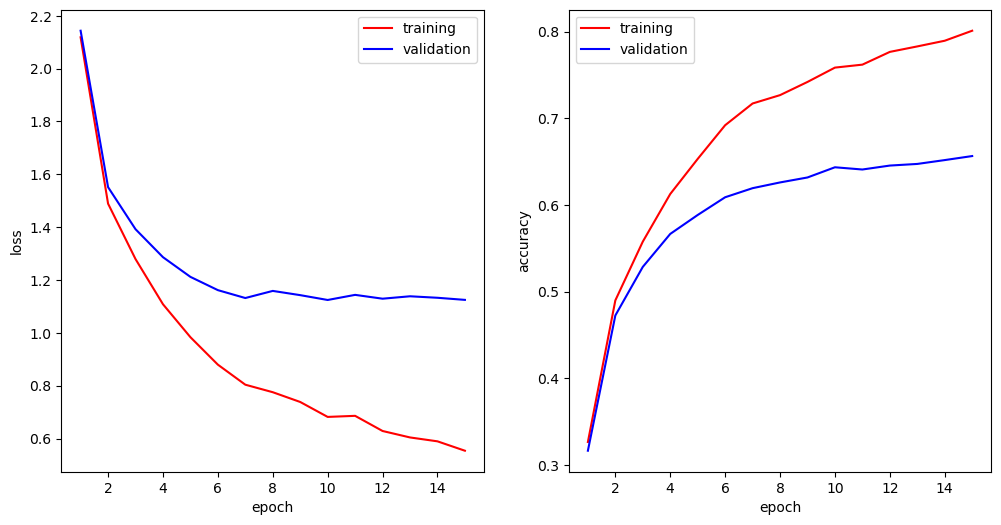

Fold #1
client 1 : 3811 samples
client 2 : 3818 samples
client 3 : 1750 samples
client 4 : 10107 samples
client 5 : 6033 samples
client 6 : 6551 samples
client 7 : 3419 samples
client 8 : 4511 samples

>>> Round 1 ...
client 1 : Loss = 0.2203, Accuracy = 0.9163
client 2 : Loss = 0.3675, Accuracy = 0.8660
client 3 : Loss = 0.2676, Accuracy = 0.9046
client 4 : Loss = 0.7768, Accuracy = 0.7234
client 5 : Loss = 0.0689, Accuracy = 0.9779
client 6 : Loss = 0.0920, Accuracy = 0.9663
client 7 : Loss = 0.3213, Accuracy = 0.8877
client 8 : Loss = 0.8289, Accuracy = 0.7102

Server :
    - training loss = 2.0436
    - training accuracy = 0.3278
    - validation loss = 2.0829
    - validation accuracy = 0.3109
        
>>> Round 2 ...
client 1 : Loss = 0.1172, Accuracy = 0.9580
client 2 : Loss = 0.2083, Accuracy = 0.9325
client 3 : Loss = 0.1491, Accuracy = 0.9431
client 4 : Loss = 0.5751, Accuracy = 0.8009
client 5 : Loss = 0.0481, Accuracy = 0.9836
client 6 : Loss = 0.0626, Accuracy = 0.9785
cli

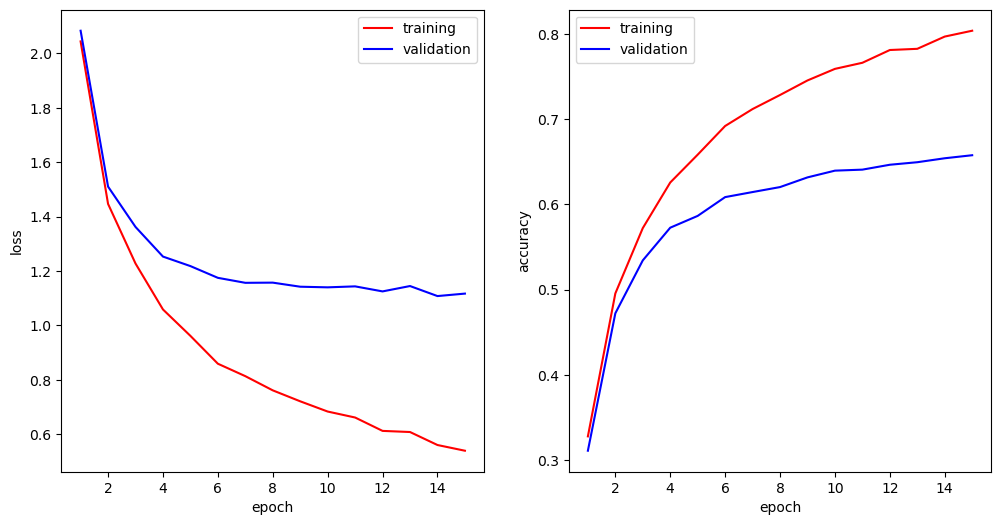

Fold #2
client 1 : 3759 samples
client 2 : 3827 samples
client 3 : 1754 samples
client 4 : 10121 samples
client 5 : 6091 samples
client 6 : 6518 samples
client 7 : 3436 samples
client 8 : 4494 samples

>>> Round 1 ...
client 1 : Loss = 0.2457, Accuracy = 0.9117
client 2 : Loss = 0.3952, Accuracy = 0.8519
client 3 : Loss = 0.2530, Accuracy = 0.9084
client 4 : Loss = 0.8634, Accuracy = 0.6927
client 5 : Loss = 0.0603, Accuracy = 0.9797
client 6 : Loss = 0.0847, Accuracy = 0.9716
client 7 : Loss = 0.3422, Accuracy = 0.8706
client 8 : Loss = 0.7182, Accuracy = 0.7333

Server :
    - training loss = 2.2123
    - training accuracy = 0.2941
    - validation loss = 2.2397
    - validation accuracy = 0.2894
        
>>> Round 2 ...
client 1 : Loss = 0.1441, Accuracy = 0.9437
client 2 : Loss = 0.1952, Accuracy = 0.9333
client 3 : Loss = 0.0948, Accuracy = 0.9680
client 4 : Loss = 0.6812, Accuracy = 0.7601
client 5 : Loss = 0.0383, Accuracy = 0.9862
client 6 : Loss = 0.0520, Accuracy = 0.9822
cli

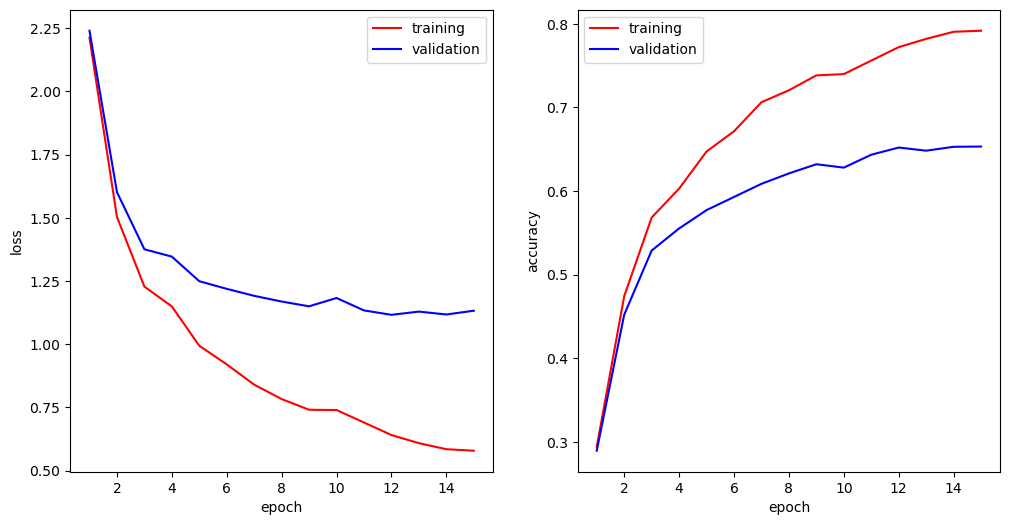

Fold #3
client 1 : 3784 samples
client 2 : 3810 samples
client 3 : 1756 samples
client 4 : 10078 samples
client 5 : 6088 samples
client 6 : 6601 samples
client 7 : 3395 samples
client 8 : 4488 samples

>>> Round 1 ...
client 1 : Loss = 0.2429, Accuracy = 0.9058
client 2 : Loss = 0.3815, Accuracy = 0.8565
client 3 : Loss = 0.2676, Accuracy = 0.9023
client 4 : Loss = 0.7631, Accuracy = 0.7256
client 5 : Loss = 0.0568, Accuracy = 0.9784
client 6 : Loss = 0.0921, Accuracy = 0.9674
client 7 : Loss = 0.3841, Accuracy = 0.8630
client 8 : Loss = 0.8832, Accuracy = 0.6925

Server :
    - training loss = 2.0557
    - training accuracy = 0.3322
    - validation loss = 2.0740
    - validation accuracy = 0.3294
        
>>> Round 2 ...
client 1 : Loss = 0.1393, Accuracy = 0.9485
client 2 : Loss = 0.2164, Accuracy = 0.9215
client 3 : Loss = 0.1103, Accuracy = 0.9634
client 4 : Loss = 0.5306, Accuracy = 0.8117
client 5 : Loss = 0.0347, Accuracy = 0.9893
client 6 : Loss = 0.0427, Accuracy = 0.9850
cli

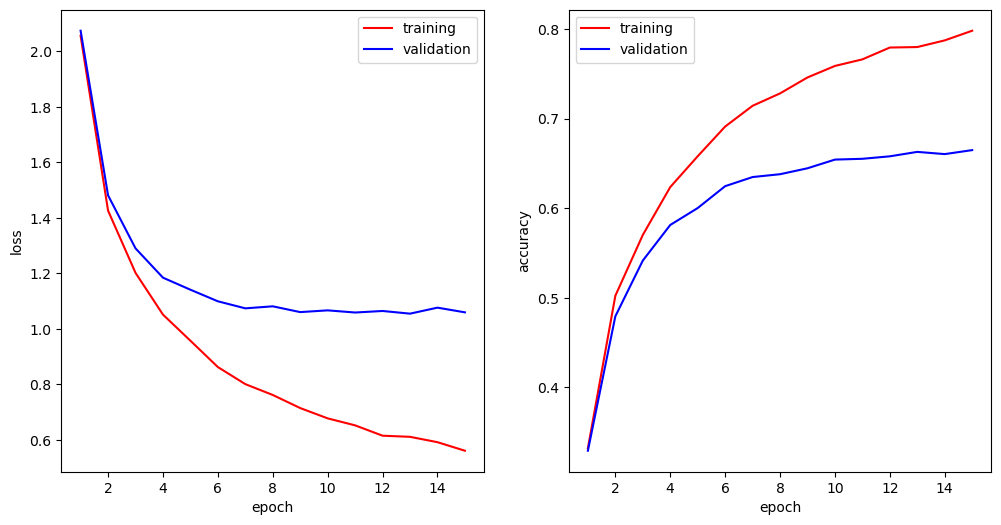

Fold #4
client 1 : 3753 samples
client 2 : 3861 samples
client 3 : 1750 samples
client 4 : 10133 samples
client 5 : 6020 samples
client 6 : 6570 samples
client 7 : 3415 samples
client 8 : 4498 samples

>>> Round 1 ...
client 1 : Loss = 0.2138, Accuracy = 0.9196
client 2 : Loss = 0.3613, Accuracy = 0.8628
client 3 : Loss = 0.2583, Accuracy = 0.8932
client 4 : Loss = 0.7860, Accuracy = 0.7288
client 5 : Loss = 0.0855, Accuracy = 0.9718
client 6 : Loss = 0.0739, Accuracy = 0.9739
client 7 : Loss = 0.3648, Accuracy = 0.8703
client 8 : Loss = 0.5992, Accuracy = 0.7740

Server :
    - training loss = 2.1508
    - training accuracy = 0.3444
    - validation loss = 2.1904
    - validation accuracy = 0.3351
        
>>> Round 2 ...
client 1 : Loss = 0.1681, Accuracy = 0.9380
client 2 : Loss = 0.2710, Accuracy = 0.9041
client 3 : Loss = 0.0900, Accuracy = 0.9690
client 4 : Loss = 0.5767, Accuracy = 0.7969
client 5 : Loss = 0.2127, Accuracy = 0.9372
client 6 : Loss = 0.0454, Accuracy = 0.9830
cli

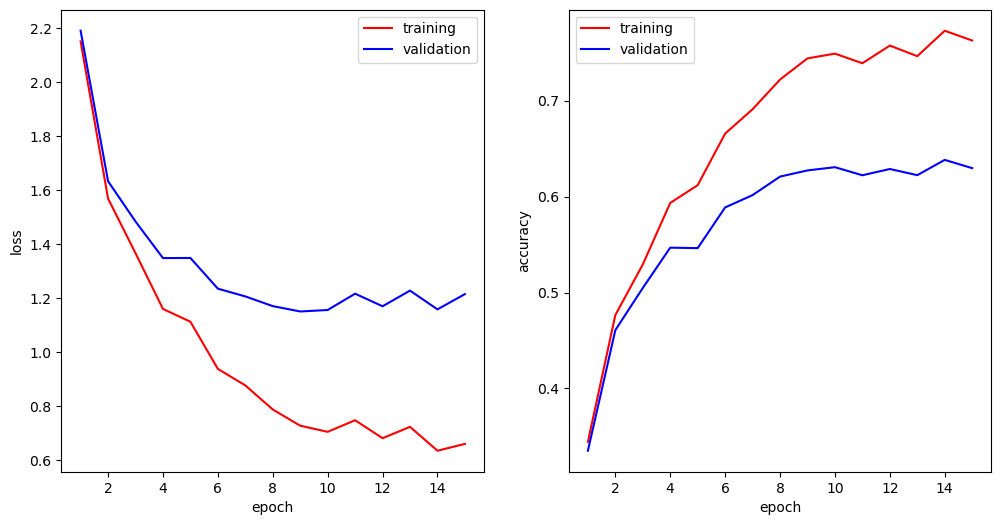

Fold #0
client 1 : 3774 samples
client 2 : 3798 samples
client 3 : 1747 samples
client 4 : 10128 samples
client 5 : 6045 samples
client 6 : 6572 samples
client 7 : 3442 samples
client 8 : 4494 samples

>>> Round 1 ...
client 1 : Loss = 0.5249, Accuracy = 0.8144
client 2 : Loss = 0.7089, Accuracy = 0.7372
client 3 : Loss = 0.7556, Accuracy = 0.7234
client 4 : Loss = 1.2509, Accuracy = 0.5596
client 5 : Loss = 0.1657, Accuracy = 0.9455
client 6 : Loss = 0.2082, Accuracy = 0.9370
client 7 : Loss = 0.7037, Accuracy = 0.7949
client 8 : Loss = 0.8735, Accuracy = 0.6408

Server :
    - training loss = 2.5305
    - training accuracy = 0.1001
    - validation loss = 2.5420
    - validation accuracy = 0.0986
        
>>> Round 2 ...
client 1 : Loss = 0.3426, Accuracy = 0.8704
client 2 : Loss = 0.5738, Accuracy = 0.7843
client 3 : Loss = 0.5182, Accuracy = 0.7992
client 4 : Loss = 0.9200, Accuracy = 0.6778
client 5 : Loss = 0.1243, Accuracy = 0.9561
client 6 : Loss = 0.1439, Accuracy = 0.9541
cli

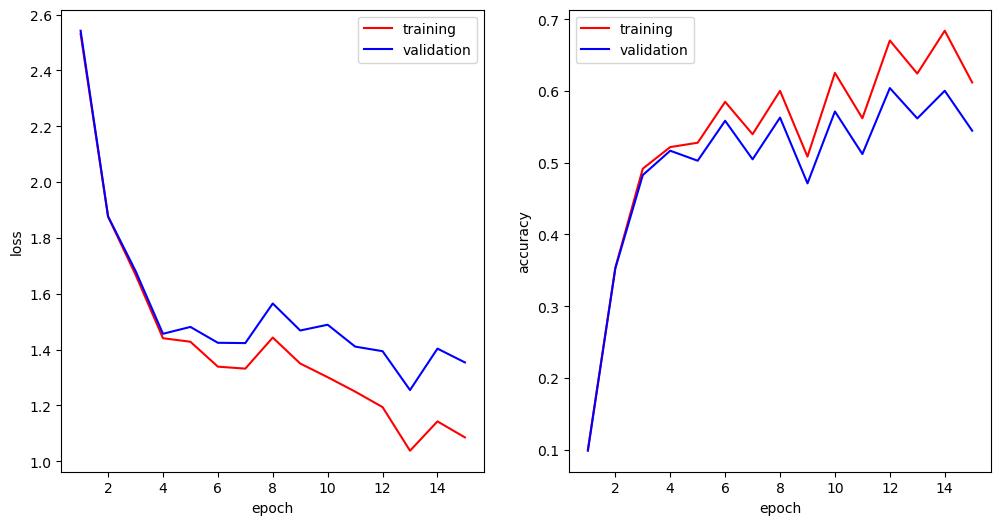

Fold #1
client 1 : 3811 samples
client 2 : 3818 samples
client 3 : 1750 samples
client 4 : 10107 samples
client 5 : 6033 samples
client 6 : 6551 samples
client 7 : 3419 samples
client 8 : 4511 samples

>>> Round 1 ...
client 1 : Loss = 0.4873, Accuracy = 0.8304
client 2 : Loss = 0.7186, Accuracy = 0.7518
client 3 : Loss = 0.8318, Accuracy = 0.6777
client 4 : Loss = 1.2086, Accuracy = 0.5716
client 5 : Loss = 0.1688, Accuracy = 0.9474
client 6 : Loss = 0.1894, Accuracy = 0.9392
client 7 : Loss = 0.6892, Accuracy = 0.7960
client 8 : Loss = 0.8365, Accuracy = 0.6597

Server :
    - training loss = 2.3320
    - training accuracy = 0.1632
    - validation loss = 2.3394
    - validation accuracy = 0.1572
        
>>> Round 2 ...
client 1 : Loss = 0.3300, Accuracy = 0.8813
client 2 : Loss = 0.5403, Accuracy = 0.8018
client 3 : Loss = 0.4734, Accuracy = 0.8017
client 4 : Loss = 0.8810, Accuracy = 0.7011
client 5 : Loss = 0.1528, Accuracy = 0.9499
client 6 : Loss = 0.1396, Accuracy = 0.9567
cli

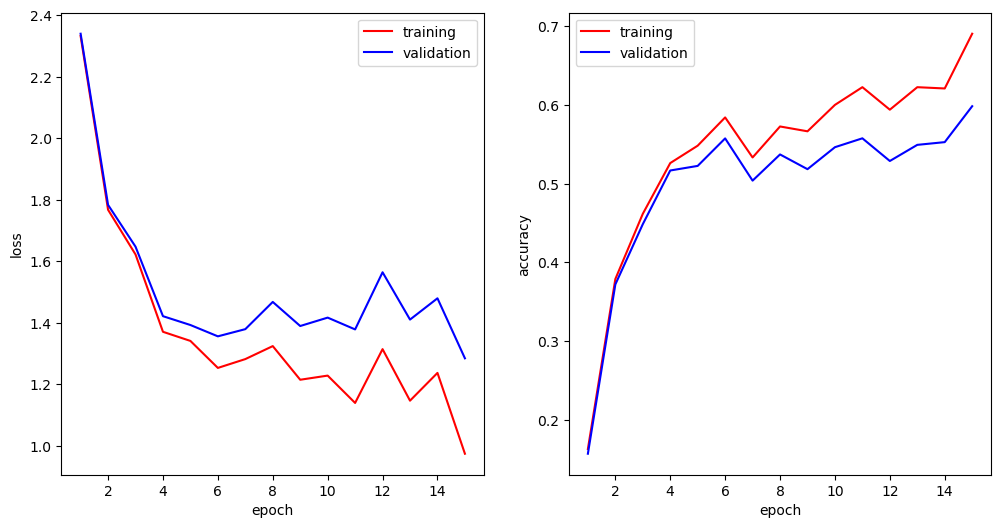

Fold #2
client 1 : 3759 samples
client 2 : 3827 samples
client 3 : 1754 samples
client 4 : 10121 samples
client 5 : 6091 samples
client 6 : 6518 samples
client 7 : 3436 samples
client 8 : 4494 samples

>>> Round 1 ...
client 1 : Loss = 0.4368, Accuracy = 0.8441
client 2 : Loss = 0.7527, Accuracy = 0.7518
client 3 : Loss = 0.7408, Accuracy = 0.7046
client 4 : Loss = 1.2548, Accuracy = 0.5579
client 5 : Loss = 0.1717, Accuracy = 0.9441
client 6 : Loss = 0.1894, Accuracy = 0.9406
client 7 : Loss = 0.6349, Accuracy = 0.8128
client 8 : Loss = 0.9110, Accuracy = 0.6570

Server :
    - training loss = 2.3229
    - training accuracy = 0.1764
    - validation loss = 2.3347
    - validation accuracy = 0.1729
        
>>> Round 2 ...
client 1 : Loss = 0.3922, Accuracy = 0.8485
client 2 : Loss = 0.5940, Accuracy = 0.7862
client 3 : Loss = 0.3941, Accuracy = 0.8357
client 4 : Loss = 0.9312, Accuracy = 0.6783
client 5 : Loss = 0.1114, Accuracy = 0.9638
client 6 : Loss = 0.1447, Accuracy = 0.9555
cli

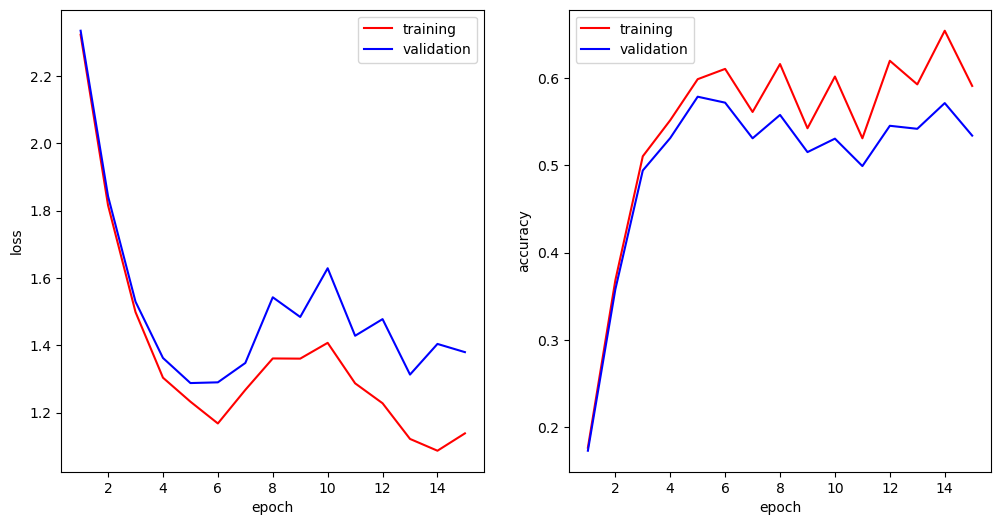

Fold #3
client 1 : 3784 samples
client 2 : 3810 samples
client 3 : 1756 samples
client 4 : 10078 samples
client 5 : 6088 samples
client 6 : 6601 samples
client 7 : 3395 samples
client 8 : 4488 samples

>>> Round 1 ...
client 1 : Loss = 0.4558, Accuracy = 0.8346
client 2 : Loss = 0.7599, Accuracy = 0.7504
client 3 : Loss = 0.7573, Accuracy = 0.7222
client 4 : Loss = 1.2044, Accuracy = 0.5761
client 5 : Loss = 0.1651, Accuracy = 0.9487
client 6 : Loss = 0.2054, Accuracy = 0.9349
client 7 : Loss = 0.7023, Accuracy = 0.8001
client 8 : Loss = 0.8959, Accuracy = 0.6528

Server :
    - training loss = 2.2468
    - training accuracy = 0.1521
    - validation loss = 2.2386
    - validation accuracy = 0.1583
        
>>> Round 2 ...
client 1 : Loss = 0.3711, Accuracy = 0.8635
client 2 : Loss = 0.5825, Accuracy = 0.7896
client 3 : Loss = 0.4518, Accuracy = 0.8127
client 4 : Loss = 0.9115, Accuracy = 0.6823
client 5 : Loss = 0.1330, Accuracy = 0.9606
client 6 : Loss = 0.1354, Accuracy = 0.9564
cli

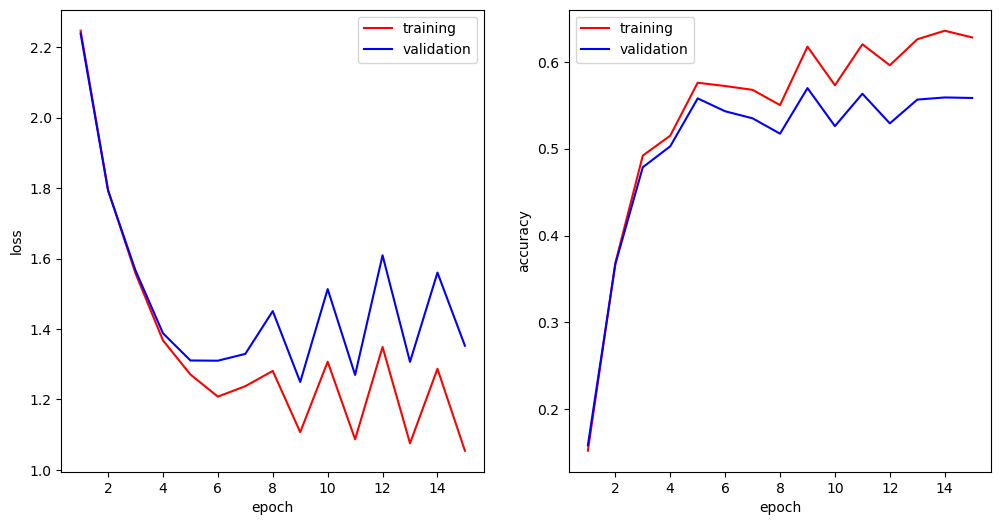

Fold #4
client 1 : 3753 samples
client 2 : 3861 samples
client 3 : 1750 samples
client 4 : 10133 samples
client 5 : 6020 samples
client 6 : 6570 samples
client 7 : 3415 samples
client 8 : 4498 samples

>>> Round 1 ...
client 1 : Loss = 0.5122, Accuracy = 0.8090
client 2 : Loss = 0.7477, Accuracy = 0.7410
client 3 : Loss = 0.8200, Accuracy = 0.6963
client 4 : Loss = 1.1269, Accuracy = 0.6004
client 5 : Loss = 0.1924, Accuracy = 0.9399
client 6 : Loss = 0.2045, Accuracy = 0.9354
client 7 : Loss = 0.7803, Accuracy = 0.7882
client 8 : Loss = 0.8072, Accuracy = 0.6615

Server :
    - training loss = 2.2484
    - training accuracy = 0.2059
    - validation loss = 2.2491
    - validation accuracy = 0.1995
        
>>> Round 2 ...
client 1 : Loss = 0.3926, Accuracy = 0.8509
client 2 : Loss = 0.4902, Accuracy = 0.8237
client 3 : Loss = 0.4188, Accuracy = 0.8282
client 4 : Loss = 0.8324, Accuracy = 0.7081
client 5 : Loss = 0.2243, Accuracy = 0.9207
client 6 : Loss = 0.1600, Accuracy = 0.9540
cli

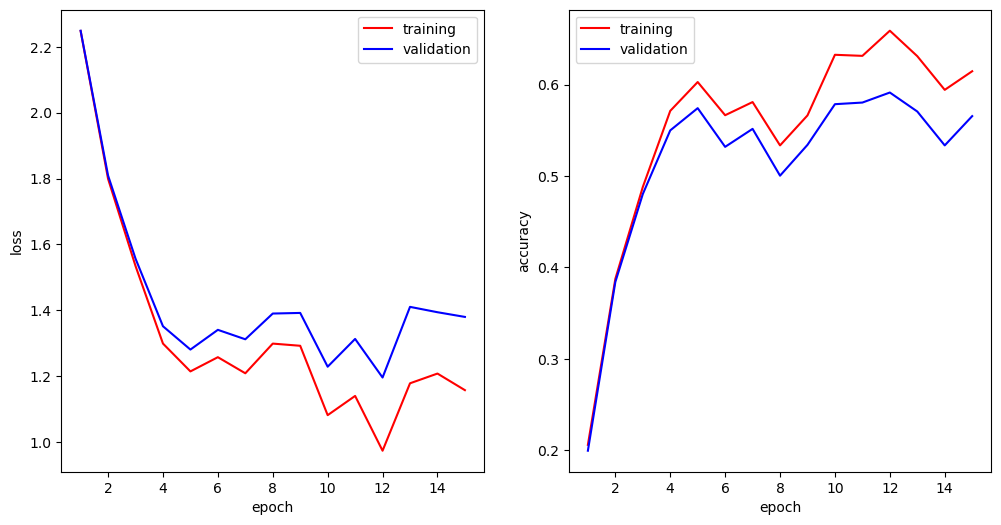

RESULTS
Momentum = 0.1000 : Accuracy = 0.6524129509925842
Momentum = 0.1000 : Accuracy = 0.5601661205291748

CPU times: user 2h 30min 25s, sys: 18.3 s, total: 2h 30min 43s
Wall time: 2h 31min 19s


In [15]:
%%time
n_splits = 5
rounds = 15
batch_size = 128
epochs = 5
momentums = [0.5, 0.95]
optimizer = optim.SGD
lr = 0.1
results = []
for momentum in momentums:
    res = run_CV(n_splits,device,rounds,epochs,batch_size,model,optimizer,lr,momentum=momentum)
    results.append((lr,res))
    
print("="*25)
print(f"RESULTS")
print("="*25)
for lr,res in results:
    print(f"Momentum = {lr:.4f} : Accuracy = {res}")
print()